# Praca domowa z ML nr 4

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Penalized_Regression/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt

## Geneorwanie zbioru danych

#### Ustalanie parametrów

In [2]:
obs_num_test = 200 #liczba obserwacji w zbiorze testowym
obs_num_train = 100 #liczba obserwacji w zbiorze treningowym
col_num = 60 #liczba kolumn
non_zero_beta = 5 #liczba niezerowych bet

np.random.seed(439669)

In [3]:
beta = np.zeros(col_num)

#losowo wybrane miejsca (indeksy), w których bety są niezerowe

nonzero_indices = np.random.choice(col_num, non_zero_beta, replace=False)
beta[nonzero_indices] = np.random.uniform(1, 3, size=non_zero_beta)

coefs = pd.DataFrame(beta, index=["x" + str(i+1) for i in range(col_num)], columns= ["beta"])
coefs[coefs["beta"] != 0]

,beta
x17,1.376857
x41,1.316285
x42,1.375845
x51,2.115492
x60,1.941353


#### Funkcja generująca dane

In [4]:
def generate_data(obs_num, col_num, betas):
    X = np.random.uniform(-1, 1, size = (obs_num, col_num))
    Y = X @ betas #prawdziwe wartości

    epsilon = np.random.randn(obs_num)
    Y_noise = Y + epsilon #dodany szum

    return Y_noise, Y, X

#### Zbiór testowy (na nim będziemy sprawdzali Bias, Wariancję oraz MSE)

In [5]:
Y_test_noise, Y_test, X_test = generate_data(obs_num_test, col_num, beta)
data = pd.DataFrame(X_test, columns = ["x" + str(i+1) for i in range(col_num)])
data["y"] = Y_test_noise
data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,y
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.035508,0.019933,-0.026153,-0.041140,0.002955,-0.005329,0.018049,0.002032,0.020945,-0.017778,...,0.004837,0.003860,0.059636,0.027814,0.050483,-0.039483,0.010652,-0.008989,0.021420,0.133053
std,0.532723,0.587868,0.572341,0.540236,0.554570,0.595265,0.578527,0.585488,0.589732,0.590117,...,0.571129,0.582784,0.567114,0.569621,0.560034,0.552303,0.553694,0.583306,0.583849,2.435126
min,-0.992334,-0.992863,-0.996702,-0.989885,-0.984209,-0.986297,-0.995988,-0.990338,-0.997575,-0.991999,...,-0.996719,-0.992481,-0.973228,-0.999748,-0.995426,-0.993286,-0.995695,-0.963150,-0.985913,-7.263652
25%,-0.452070,-0.481193,-0.474240,-0.483797,-0.475577,-0.522316,-0.437395,-0.532336,-0.468813,-0.594158,...,-0.474960,-0.445759,-0.440095,-0.484221,-0.405692,-0.535194,-0.472373,-0.535110,-0.499720,-1.365238
50%,-0.009315,0.042827,-0.079470,-0.091285,-0.010457,-0.044371,0.018227,-0.002254,0.000929,-0.006500,...,0.005445,-0.011603,0.113442,0.011851,0.004419,-0.045862,0.016754,-0.016772,0.085498,0.183877
75%,0.357933,0.540309,0.451474,0.398874,0.458041,0.504481,0.552468,0.538471,0.559139,0.503391,...,0.468533,0.543641,0.562366,0.496880,0.499966,0.402112,0.484631,0.507673,0.547050,1.657701
max,0.970758,0.979914,0.966020,0.984659,0.983119,0.993658,0.993532,0.993455,0.999518,0.971846,...,0.996220,0.990448,0.993665,0.998752,0.969158,0.968705,0.996783,0.953011,0.998217,6.659256


## Analiza wpływu wielkości $ \lambda $ na model


In [6]:
num_of_runs = 250 #ile razy będziemy powtarzać eksperyment
N = 60 #ile alpha
alphas = np.logspace(-3, 3, N) #alphy dla których będziemy szacować modele

#### Ridge regression

In [7]:
mse_vals_r = np.zeros(N)
bias_vals_r = np.zeros(N)
var_vals_r = np.zeros(N)

In [8]:
for i, alpha in enumerate(alphas):
    predicted_vals = np.zeros(shape = (num_of_runs, obs_num_test))

    for _ in range(num_of_runs):
        #generujemy nowy zbiór danych, na którym będziemy szcowac model
        Y_train_noise, Y_train, X_train = generate_data(obs_num_train, col_num, beta)
        ridge_m = Ridge(alpha = alpha, max_iter = 100000)

        #szacujemy model na nowo wygenerowanym zbiorze danych
        ridge_m.fit(X_train, Y_train_noise)
        
        #przewidujemy wartości dla wcześniej ustalonego zbioru testowego korzystając z nowo wygenerowanego zbioru
        predictions = ridge_m.predict(X_test)
        predicted_vals[_,:] = predictions

    mse_vals_r[i] = np.mean(((predicted_vals - Y_test)**2))
    #średnia dla poszczególnej obserwacji (poszczególnego punktu)
    mean = predicted_vals.mean(axis = 0)
    bias_vals_r[i] = np.mean((mean - Y_test)**2)
    var_vals_r[i] = np.mean(np.var(predicted_vals, axis = 0))

#### Lasso regression

In [9]:
mse_vals_l = np.zeros(N)
bias_vals_l = np.zeros(N)
var_vals_l = np.zeros(N)

In [10]:
for i, alpha in enumerate(alphas):
    predicted_vals = np.zeros(shape = (num_of_runs, obs_num_test))

    for _ in range(num_of_runs):
        #generujemy nowy zbiór danych, na którym będziemy szcowac model
        Y_train_noise, Y_train, X_train = generate_data(obs_num_train, col_num, beta)
        lasso_m = Lasso(alpha = alpha, max_iter = 100000)

        #szacujemy model na nowo wygenerowanym zbiorze danych
        lasso_m.fit(X_train, Y_train_noise)
        
        #przewidujemy wartości dla wcześniej ustalonego zbioru testowego korzystając z nowo wygenerowanego zbioru
        predictions = lasso_m.predict(X_test)
        predicted_vals[_,:] = predictions

    mse_vals_l[i] = np.mean((predicted_vals - Y_test)**2)

    #średnia dla poszczególnej obserwacji (poszczególnego punktu)
    mean = predicted_vals.mean(axis = 0)
    bias_vals_l[i] = np.mean((mean - Y_test)**2)
    var_vals_l[i] = np.mean(np.var(predicted_vals, axis = 0))

### Wykresy MSE, Wariancji oraz Bias w zależności od modelu oraz $\lambda$

[]

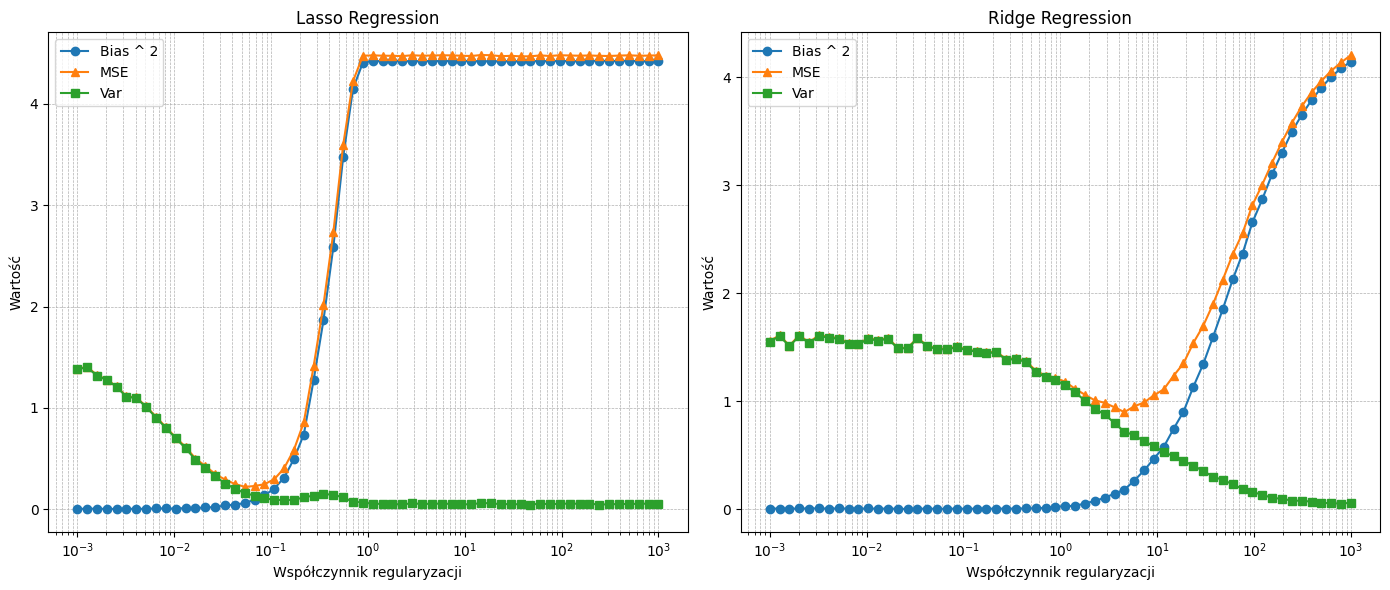

In [11]:
fig, axs = plt.subplots(1,2, figsize = (14, 6))

axs[0].semilogx(alphas, bias_vals_l, marker = "o", label = "Bias ^ 2")
axs[0].semilogx(alphas, mse_vals_l, marker = "^", label = "MSE")
axs[0].semilogx(alphas, var_vals_l, marker = "s", label = "Var")
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xlabel("Współczynnik regularyzacji")
axs[0].set_ylabel("Wartość")
axs[0].set_title("Lasso Regression")
axs[0].legend()


axs[1].semilogx(alphas, bias_vals_r, marker = "o", label = "Bias ^ 2")
axs[1].semilogx(alphas, mse_vals_r, marker = "^", label = "MSE")
axs[1].semilogx(alphas, var_vals_r, marker = "s", label = "Var")
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xlabel("Współczynnik regularyzacji")
axs[1].set_ylabel("Wartość")
axs[1].set_title("Ridge Regression")
axs[1].legend()

plt.tight_layout()
plt.plot()

## Analiza i odpowiedzi na pytania

### Pytanie 1

Jak można zauważyć na powyższych wykresach, zmiany wartości parametru regularyzującego $\lambda$ prowadzą do zbliżonych zachowań MSE, biasu oraz wariancji w zależności od szacowanego modelu. W przypadku obu regresji obserwujemy wzrost biasu wraz ze wzrostem parametru regularyzacyjnego oraz spadek wariancji. Innymi słowy, modele stają się coraz prostsze, tzn. mniej złożone (wzrost biasu przy zwiększaniu $\lambda$ oznacza, że silniej karzemy modele zawierające wiele parametrów) oraz bardziej stabilne (spadek wariancji).

Zarówno w przypadku regresji lasso, jak i regresji ridge, wykres MSE na zbiorze testowym przyjmuje charakterystyczny kształt litery U. Dla bardzo małych wartości $\lambda$ model jest niedostatecznie regularyzowany, co prowadzi do overfittingu i wysokiej wariancji. Z kolei dla dużych wartości $\lambda$ regularyzacja jest zbyt silna, przez co model staje się zbyt uproszczony i zaczyna dominować bias (underfitting).

Należy również zauważyć, że w przypadku regresji lasso wzrost MSE oraz biasu następuje szybciej (jest bardziej stromy) od pewnego momentu niż w przypadku regresji ridge. Wynika to z różnicy w mechanizmach regularyzacji:

$\textbf{Regresja lasso}$ ($\ell_1$-regularizacja) prowadzi do zerowania niektórych współczynników. W efekcie, po przekroczeniu pewnej wartości $\lambda$, model może utracić istotne zmienne, co powoduje gwałtowny wzrost biasu i MSE.
\
\
$\textbf{Regresja ridge}$ ($\ell_2$-regularizacja) zamiast zerować współczynniki, jedynie je zmniejsza. Dzięki temu zmiany są bardziej stopniowe, a wzrost biasu i MSE przy dużych wartościach $\lambda$ jest łagodniejszy.


W szczególności regresja lasso wydaje się znacznie bardziej karać zbyt złożone modele niż regresja ridge, ponieważ może całkowicie eliminować niektóre zmienne, co w skrajnych przypadkach prowadzi do utraty ważnych informacji.


### Pytanie 2

MSE, czyli $\textit{Mean Squared Error}$ – błąd średniokwadratowy, mierzy oczekiwane kwadratowe odchylenie estymatora $\hat{\theta}$ od prawdziwej wartości parametru $\theta$, tzn.
\begin{equation}
MSE(\hat{\theta}) = \mathbb{E} (\theta -\hat{\theta})^2.
\end{equation}
W szczególności MSE można rozbić na dwie składowe – bias oraz wariancję. Bias mierzy systematyczny błąd estymatora, czyli jak bardzo jego wartość odbiega od prawdziwego parametru, a wariancja pokazuje, jak wyniki (w uproszczeniu) modelu zmieniają się przy różnych danych treningowych. 

Pozostając w świecie regresji liniowej, jeśli przez $\hat{f}(x)$ oznaczymy estymator rzeczywistej wartości funkcji $f(x)$ (działamy na zbiorach treningowych), to zachodzi następująca równość:
\begin{equation}\tag{2}
\text{MSE} = \underbrace{\Big(\mathbb{E}[\hat{f}(x)] - f(x)\Big)^2}_{\text{bias}^2} + \underbrace{\mathbb{E}\Big[\Big(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\Big)^2\Big]}_{\text{wariancja}} + \sigma^2,
\end{equation}
gdzie $\sigma^2$ to wariancja wynikająca z szumu (losowego zakłócenia) w danych, której nie da się zredukować poprawą modelu (naturalnie występujące zakłócenia).

Rozkład MSE na składowe pokazuje trade-off pomiędzy bias a wariancją. Modele o niskim biasie zwykle mają wysoką wariancję, natomiast modele o wysokim biasie mają niską wariancję.

### Pytanie 3

Znając zależność biasu i wariancji od parametru regularyzacyjnego oraz rozkład błędu średniokwadratowego, możemy stwierdzić, że istnieje pewna optymalna wartość $\lambda$, dla której MSE osiąga minimum. Wynika to z faktu, że wariancja zazwyczaj maleje wraz ze wzrostem $\lambda$, podczas gdy bias rośnie, co prowadzi do charakterystycznego wykresu MSE o kształcie przypominającym literę U (choć może być on mniej symetryczny lub spłaszczony w zależności od danych).  

Znalezienie optymalnego $\lambda$ polega na wyznaczeniu punktu, w którym dalsza redukcja wariancji przestaje być opłacalna, ponieważ wzrost biasu powoduje ostateczny wzrost MSE.


### Pytanie 4

Modele Ridge i Lasso różnią się przede wszystkim w sposobie nakładania kar na współczynniki, co ma bezpośredni wpływ na równowagę między biasem a wariancją. W regresji Ridge, kara jest nakładana na kwadrat wartości współczynników, co sprawia, że model zmniejsza współczynniki w sposób równomierny, ale z reguły ich nie zeruje całkowicie. Stąd regresja Ridge lepiej daje sobie radę jeśli występują współliniowości w modelu,czyli kiedy predyktory są ze sobą silnie skorelowane. Ridge „rozprasza” wagę między skorelowane zmienne, zamiast je eliminować, co może być korzystne w zadaniach, w których ważne jest zachowanie informacji o wszystkich cechach. 
\
\
Regresja Lasso, natomiast nakłada karę na wartość bezwzględną współczynników, co powoduje, że niektóre z nich mogą zostać całkowicie zredukowane do zera. Z tego powodu Lasso zwykle prowadzi do silniejszej redukcji wariancji (dzięki eliminacji zbędnych cech), choć wiąże się to z większym biasem. Kluczową cechą regresji Lasso jest selekcja zmiennych (tzw. sparsity), co jest szczególnie przydatne w przypadkach, gdy mamy dużą liczbę zmiennych, ale tylko część z nich jest rzeczywiście istotna. Eliminowanie nieistotnych zmiennych zmniejsza wariancję i upraszcza model, jednak kosztem wzrostu biasu.
 